# TP: MNIST with Neural Networks (NN)
## SD-TSIA 210 | Télécom-Paris 2024
## Giovanni Benedetti da Rosa (Gr. 2) & Carlos Gruss (Gr. 3)

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

import keras
from keras.datasets import mnist

import sys

print("Using Python version " + str(sys.version))
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))


Using Python version 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
Using tensorflow version 2.15.0
Using keras version 2.15.0


## Loading and preparing the MNIST dataset
Load the MNIST dataset made available by keras.datasets. Check the size of the training and testing sets. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [2]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Let's check the size of the data
print("Training images size: " + str(train_images.shape))
print("Training labels size: " + str(train_labels.shape))
print("Test images size: " + str(test_images.shape))
print("Test labels size: " + str(test_labels.shape))

Training images size: (60000, 28, 28)
Training labels size: (60000,)
Test images size: (10000, 28, 28)
Test labels size: (10000,)


The MNIST database contains 60,000 training images and 10,000 testing images.
Using the pyplot package, visualize the first sample of the training set:

<div class='alert alert-block alert-info'>
            Code:</div>

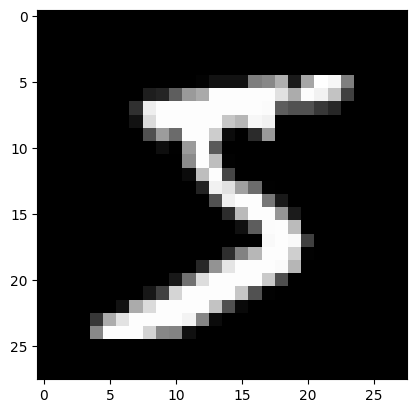

In [3]:
plt.imshow(train_images[0], cmap='gray')
plt.show()

In [4]:
train_images[0].astype('float').mean()

35.108418367346935

The database contains images of handwritten digits. Hence, they belong to one of 10 categories, depending on the digit they represent. 
Reminder: in order to do multi-class classification, we use the softmax function, which outputs a multinomial probability distribution. That means that the output to our model will be a vector of size $10$, containing probabilities (meaning that the elements of the vector will be positive sum to $1$).
For easy computation, we want to true labels to be represented with the same format: that is what we call **one-hot encoding**. For example, if an image $\mathbf{x}$ represents the digit $5$, we have the corresponding one_hot label (careful, $0$ will be the first digit): 
$$ \mathbf{y} = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] $$
Here, you need to turn train and test labels to one-hot encoding using the following function: 

<div class='alert alert-block alert-info'>
            Code:</div>

In [5]:
# One-hot encode target column
train_labels = tf.one_hot(train_labels, 10).numpy()
test_labels = tf.one_hot(test_labels, 10).numpy()

Images are black and white, with size $28 \times 28$. We will work with them using a simple linear classification model, meaning that we will have them as vectors of size $(784)$.
You should then transform the images to the size $(784)$ using the numpy function ```reshape```.

Then, after casting the pixels to floats, normalize the images so that they have zero-mean and unitary deviation. Be careful to your methodology: while you have access to training data, you may not have access to testing data, and must avoid using any statistic on the testing dataset.

<div class='alert alert-block alert-info'>
            Code:</div>

In [6]:
# Reshape images to vectors of pixels
img_rows, img_cols = train_images.shape[1], train_images.shape[2]
train_images = train_images.reshape(train_images.shape[0], img_rows * img_cols)
test_images = test_images.reshape(test_images.shape[0], img_rows * img_cols)

# Cast pixels from uint8 to float32
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?
mean = np.mean(train_images)
std = np.std(train_images)
train_images = (train_images - mean) / std
test_images = (test_images - mean) / std

# First part: working with Numpy

Look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf) for some basic information on how to use numpy.

### Defining the model 

We will here create a simple, linear classification model. We will take each pixel in the image as an input feature (making the size of the input to be $784$) and transform these features with a weight matrix $\mathbf{W}$ and a bias vector $\mathbf{b}$. Since there is $10$ possible classes, we want to obtain $10$ scores. Then, 
$$ \mathbf{W} \in \mathbb{R}^{784 \times 10} $$
$$ \mathbf{b} \in \mathbb{R}^{10} $$

and our scores are obtained with:
$$ \mathbf{z} = \mathbf{W}^{T} \mathbf{x} +  \mathbf{b} $$

where $\mathbf{x} \in \mathbb{R}^{784}$ is the input vector representing an image.
We note $\mathbf{y} \in \mathbb{R}^{10}$ as the target one_hot vector. 

Here, you fist need to initialize $\mathbf{W}$ and $\mathbf{b}$ using ```np.random.normal``` and ```np.zeros```, then compute $\mathbf{z}$.
<div class='alert alert-block alert-info'>
            Code:</div>

In [7]:
# To avoid implementing a complicated gradient back-propagation,
# we will try a very simple architecture with one layer
def initLayer(n_input, n_output):
    """
    Initialize the weights, return the number of parameters
    Inputs: n_input: the number of input units - int
          : n_output: the number of output units - int
    Outputs: W: a matrix of weights for the layer - numpy ndarray
           : b: a vector bias for the layer - numpy ndarray
           : nb_params: the number of parameters  - int
    """
    # Create W at the right size with a normal distribution
    W = np.random.normal(size=(n_input, n_output))

    # Create b at the right size, with zeros
    b = np.zeros(n_output)
    nb_params = n_input*n_output + n_output
    
    return W, b, nb_params

In [8]:
n_input = train_images.shape[1]
n_output = train_labels.shape[1]
W, b, nb_params = initLayer(n_input, n_output)

<div class='alert alert-block alert-info'>
            Code:</div>

In [9]:
def forward(W, b, X):
    """
    Perform the forward propagation
    Inputs: W: the weights - numpy ndarray
          : b: the bias - numpy ndarray
          : X: the batch - numpy ndarray
    Outputs: z: outputs - numpy ndarray
    """
    z = X @ W + b
    return z

### Computing the output 

To obtain classification probabilities, we use the softmax function:
$$ \mathbf{o} = softmax(\mathbf{z}) \text{         with          } o_i = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)} $$

The usual difficulty with the softmax function is the possibility of overflow when the scores $z_i$ are already large. What trick can we use to ensure we will not encounter any overflow ? 

Since a softmax is not affected by a shift affecting the whole vector $\mathbf{z}$:

$$ 
\frac{\exp(z_i - c)}{\sum_{j=0}^{9} \exp(z_j - c)} =  \frac{\exp(c) \exp(z_i)}{\exp(c) \sum_{j=0}^{9} \exp(z_j)} = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)}
$$

We can just shift the pre-activation values by ther maximum, thus making all the values less than or equal to zero. Thus taking the exponential of them will no longer pose a risk of overflow.

<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
def softmax(z):
    """
    Perform the softmax transformation to the pre-activation values
    Inputs: z: the pre-activation values - numpy ndarray
    Outputs: out: the activation values - numpy ndarray
    """
    max_z = np.max(z)
    return np.exp(z - max_z) / np.sum(np.exp(z - max_z))

### Making updates

We define a learning rate $\eta$. The goal is to be able to apply updates:
$$ \mathbf{W}^{t+1} = \mathbf{W}^{t} - \nabla_{\mathbf{W}} l_{MLE} $$

In order to do this, we will compute this gradient (and the bias) in the function ```update```. 

In the next function ```updateParams```, we will actually apply the update with regularization. 

Reminder: The gradient $\nabla_{\mathbf{W}} l_{MLE}$ is the matrix containing the partial derivatives 

$$ 
\left[\frac{\delta l_{MLE}}{\delta W_{ij}}\right]_{i=1...784, \,\, j=1...10} 
$$

**Remark**: Careful, the usual way of implementing this in Python has the dimensions of $\mathbf{W}$ reversed compared to the notation of the slides.

Coordinate by coordinate, we obtain the following update: 
$$ W_{ij}^{t+1} = W_{ij}^{t} - \eta \frac{\delta l_{MLE}}{\delta W_{ij}} $$

Via the chain rule, we obtain, for an input feature $i \in [0, 783]$ and a output class $j \in [0, 9]$: $$\frac{\delta l_{MLE}}{\delta W_{ij}} = \frac{\delta l_{MLE}}{\delta z_{j}} \frac{\delta z_j}{\delta W_{ij}}$$ 

It's easy to compute that $\frac{\delta z_j}{\delta W_{ij}} = x_i$

We compute the softmax derivative, to obtain:
$$ \nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y} $$

Hence, $\frac{\delta l_{MLE}}{\delta z_{j}} = o_j - y_j$ and we obtain that $$\frac{\delta l_{MLE}}{\delta W_{ij}} = (o_j - y_j) x_i$$

This can easily be written as a scalar product, and a similar computation (even easier, actually) can be done for $\mathbf{b}$. 

Noting $\nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y}$ as ```grad``` in the following function, compute the gradients $\nabla_{\mathbf{W}} l_{MLE}$ and $\nabla_{\mathbf{b}} l_{MLE}$ in order to call the function ```updateParams```.

Note: The regularizer and the weight_decay $\lambda$ are used in ```updateParams```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [11]:
def update(eta, W, b, grad, X, regularizer, weight_decay):
    """
    Perform the update of the parameters
    Inputs: eta: the step-size of the gradient descent - float 
          : W: the weights - ndarray
          : b: the bias -  ndarray
          : grad: the gradient of the activations w.r.t. to the loss -  list of ndarray
          : X: the data -  ndarray
          : regularizer: 'L2' or None - the regularizer to be used in updateParams
          : weight_decay: the weight decay to be used in updateParams - float
    Outputs: W: the weights updated -  ndarray
           : b: the bias updated -  ndarray
    """
    grad_w = np.outer(X, grad.T)
    grad_b = grad

    W = updateParams(W, grad_w, eta, regularizer, weight_decay)
    b = updateParams(b, grad_b, eta, regularizer, weight_decay)
    
    return W, b

The update rule is affected by regularization. We implement two cases: No regularization, or L2 regularization. Use the two possible update rules to implement the following function: <div class='alert alert-block alert-info'>
            Code:</div>

In [12]:
def updateParams(param, grad_param, eta, regularizer=None, weight_decay=0.):
    """
    Perform the update of the parameters
    Inputs: param: the network parameters - ndarray
          : grad_param: the updates of the parameters - ndarray
          : eta: the step-size of the gradient descent - float
          : weight_decay: the weight-decay - float
    Outputs: the parameters updated - ndarray
    """
    if regularizer == None:
        output = param - eta * grad_param 
        return output
    elif regularizer == 'L2':
        output = param - eta * (grad_param + weight_decay * param)
        return output
    else:
        raise NotImplementedError

### Computing the Accuracy

Here, we simply use the model to predict the class (by taking the argmax of the output !) for every example in ```X```, and count the number of times the model is right, to output the accuracy.
<div class='alert alert-block alert-info'>
            Code:</div>

In [13]:
def computeAcc(W, b, X, labels):
    """
    Compute the loss value of the current network on the full batch
    Inputs: 
          : W: the weights - list of ndarray
          : B: the bias - list of ndarray
          : X: the batch - ndarray
          : labels: the labels corresponding to the batch
    Outputs: 
           : accuracy: the ratio of examples that are well-classified - float
    """ 
    # Forward propagation
    z = forward(W, b, X)
 
    # Compute the softmax and the prediction
    out = softmax(z)
    pred = np.argmax(out, axis=1)
    
    # Compute the accuracy
    accuracy = np.mean(np.argmax(labels, axis=1) == pred)
      
    return accuracy

### Preparing training

The following hyperparameters are given. Next, we can assemble all the function previously defined to implement a training loop. We will train the classifier on **one epoch**, meaning that the model will see each training example once. 

In [14]:
# Optimization
eta = 0.01
regularizer = 'L2'
weight_decay = 0.0001

# Training
log_interval = 5000

<div class='alert alert-block alert-info'>
            Code:</div>

In [15]:
# Data structures for plotting
g_train_acc = []
g_valid_acc = []

n_training = train_images.shape[0]

#######################
### Learning process ##
#######################
for j in range(n_training):
    # Getting the example
    X, y = train_images[j], train_labels[j]

    # Forward propagation
    z = forward(W, b, X)

    # Compute the softmax
    out = softmax(z)

    # Compute the gradient at the top layer
    derror = out - y  # This is o - y

    # Update the parameters
    W, b = update(eta, W, b, derror, X, regularizer, weight_decay)

    if j % log_interval == 0:
        # Every log_interval examples, look at the training accuracy
        train_accuracy = computeAcc(W, b, train_images, train_labels)

        # And the testing accuracy
        test_accuracy = computeAcc(W, b, test_images, test_labels)

        g_train_acc.append(train_accuracy)
        g_valid_acc.append(test_accuracy)
        # result_line = str(int(j)) + " " + str(train_accuracy) + \
        #     " " + str(test_accuracy) + " " + str(eta)
        result_line = f'Iteration {j} - Train accuracy: {train_accuracy:.3f} - Test accuracy: {test_accuracy:.3f} - Learning rate: {eta}'
        print(result_line)

g_train_acc.append(train_accuracy)
g_valid_acc.append(test_accuracy)
# result_line = "Final result:" + " " + \
#     str(train_accuracy) + " " + str(test_accuracy) + " " + str(eta)
result_line = f'Final result - Train accuracy: {train_accuracy:.3f} - Test accuracy: {test_accuracy:.3f} - Learning rate: {eta}'
print(result_line)

Iteration 0 - Train accuracy: 0.093 - Test accuracy: 0.096 - Learning rate: 0.01
Iteration 5000 - Train accuracy: 0.795 - Test accuracy: 0.799 - Learning rate: 0.01
Iteration 10000 - Train accuracy: 0.840 - Test accuracy: 0.846 - Learning rate: 0.01
Iteration 15000 - Train accuracy: 0.845 - Test accuracy: 0.851 - Learning rate: 0.01
Iteration 20000 - Train accuracy: 0.855 - Test accuracy: 0.856 - Learning rate: 0.01
Iteration 25000 - Train accuracy: 0.864 - Test accuracy: 0.870 - Learning rate: 0.01
Iteration 30000 - Train accuracy: 0.856 - Test accuracy: 0.859 - Learning rate: 0.01
Iteration 35000 - Train accuracy: 0.857 - Test accuracy: 0.855 - Learning rate: 0.01
Iteration 40000 - Train accuracy: 0.878 - Test accuracy: 0.878 - Learning rate: 0.01
Iteration 45000 - Train accuracy: 0.873 - Test accuracy: 0.872 - Learning rate: 0.01
Iteration 50000 - Train accuracy: 0.867 - Test accuracy: 0.874 - Learning rate: 0.01
Iteration 55000 - Train accuracy: 0.873 - Test accuracy: 0.870 - Learn

What can you say about the performance of this simple linear classifier ?
<div class='alert alert-block alert-warning'>
            Answer:</div>

We observe that we reach a good performance very quickly, in only 5000 iterations, and that learning seems to slow down significantly around 3500 iterations. The overall accuracy is good, both in the train and test dataset, showing that there doesn't seem to be overfitting and we're achieving a good bias-variance balance.

For such a simple classifier that we can train very quickly, the performance is good. 

# Second part: Autoencoder with Keras

## Autoencoder and PCA

First, we will try to connect the representation produced by Principal Component Analysis with what is learnt by a simple, linear, autoencoder. We will use the ```scikit-learn``` implementation of the ```PCA``` to obtain the two first components (hint: use the attribute ```.components_```), and visualize them:
<div class='alert alert-block alert-info'>
            Code:</div>

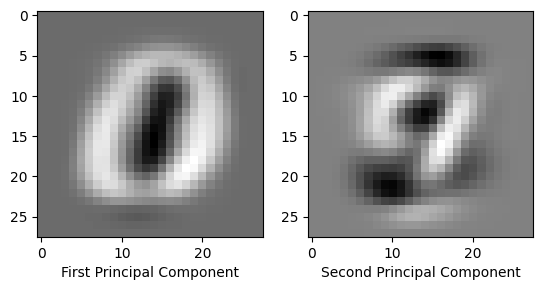

In [16]:
from sklearn.decomposition import PCA

# Let's find the first 2 PCA components
num_components = 2
pca = PCA(n_components=num_components).fit(train_images)

# Reshape so they resemble images and we can print them
eigen_mnist = pca.components_.reshape(num_components, img_rows, img_cols)

# Show the reshaped principal components
f, ax = plt.subplots(1, 2)
ax[0].imshow(eigen_mnist[0], cmap='gray')
ax[0].set_xlabel('First Principal Component')
ax[1].imshow(eigen_mnist[1], cmap='gray')
ax[1].set_xlabel('Second Principal Component')
plt.show()

In [17]:
# Print the variance explained by those components
print(f'Explained variance by the first {num_components} components: {pca.explained_variance_}')

# Print the ratio of explained variance
print(f'Ratio of explained variance by the first {num_components} components: {pca.explained_variance_ratio_}')
print(f'Total ratio of explained variance by the first {num_components} components: {np.sum(pca.explained_variance_ratio_)}')

Explained variance by the first 2 components: [53.901375 39.411983]
Ratio of explained variance by the first 2 components: [0.0970476  0.07095995]
Total ratio of explained variance by the first 2 components: 0.16800755262374878


Comment on the visualization in relation to the variance explained by only keeping the two principal components:
<div class='alert alert-block alert-warning'>
            Answer:</div>

First, we can observe that only keeping two components makes it so we're not really explaining much of the variance of the data (only 17% approximately). Still, it's impressive that a reduction from 784 dimensions to only 2 manages to capture some of the structure of the data. Visually, we observe the first PCA component seems to represent a zero while the second seems to represent a nine. Intuitively, this seems to make sense, since we could represent digits by linearly combining these two.

### Implementing the Autoencoder with Keras

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

Now, we will use Keras to implement the autoencoder. You can take a look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) for some basic commands to use keras.

In this first case, we implement a **simple linear autoencoder**. Build it in order to have the same capacity as the PCA decomposition (2 hidden dimensions !) we made just above. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [19]:
# Input layer
input_layer = Input(shape=(img_rows*img_cols,), name='input')

# Encoding layer
latent_view = Dense(num_components, name='encoded')(input_layer)

# Decoding layer
output_layer = Dense(img_rows*img_cols, name='output')(latent_view)

ae_model = Model(input_layer, output_layer, name='ae_model')

ae_model.summary()


Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoded (Dense)             (None, 2)                 1570      
                                                                 
 output (Dense)              (None, 784)               2352      
                                                                 
Total params: 3922 (15.32 KB)
Trainable params: 3922 (15.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


What loss shoud we use ? Choose the usual one and import it directly from Keras. You can use a simple ```SGD``` optimizer, and then compile the model; finally, train it to rebuild images from the original examples. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [20]:
from tensorflow.keras.losses import MeanSquaredError

loss = MeanSquaredError()
optimizer = SGD(learning_rate=1e-1) 

ae_model.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images, test_images))

Epoch 1/10

469/469 [==============================] - 1s 2ms/step - loss: 0.7514 - val_loss: 0.6741
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.6557 - val_loss: 0.6394
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.6364 - val_loss: 0.6311
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.6306 - val_loss: 0.6243
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.6242 - val_loss: 0.6191
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.6196 - val_loss: 0.6165
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.6176 - val_loss: 0.6158
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.6167 - val_loss: 0.6155
Epoch 9/10
469/469 [==============================] - 1s 2ms/step - loss: 0.6163 - val_loss: 0.6152
Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss: 0.6160 - val_loss: 0.615

Assuming that the name of your layer (obtained through the command ```model.summary()```) is ```'layer'```, here is the way to obtained the weights. Visualize the weights of the encoder and compare them to the two components obtained through the PCA.

In [21]:
weights_encoded, bias_encoded = ae_model.get_layer('encoded').get_weights()
weights_output, bias_output = ae_model.get_layer('output').get_weights()

<div class='alert alert-block alert-info'>
            Code:</div>

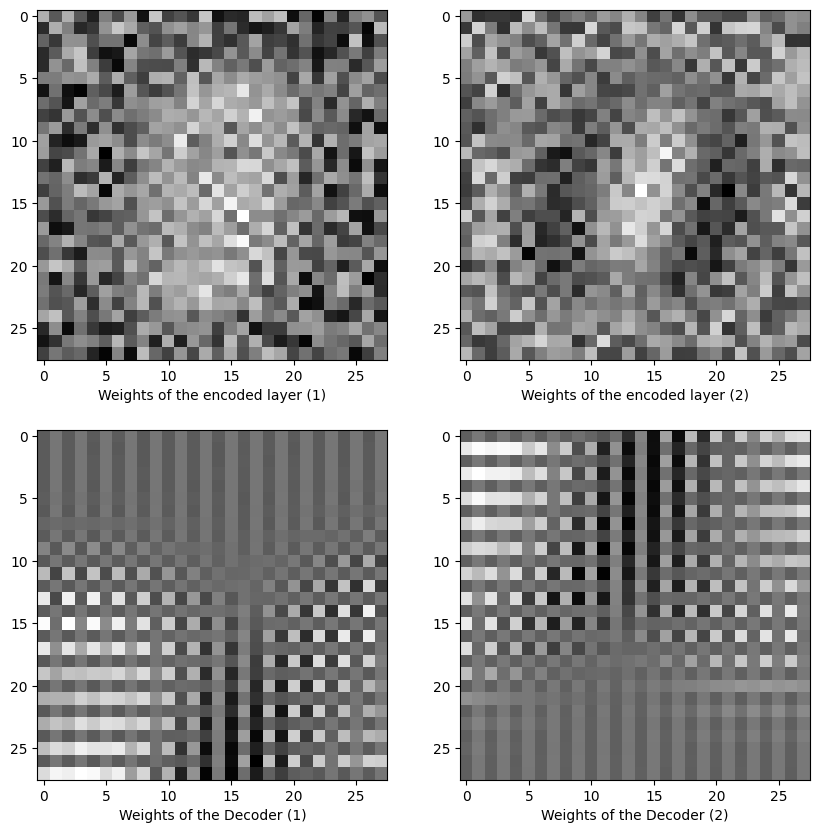

In [22]:
# Show the two dimensions of the encoder, in a similar manner to the principal components
# (after reshaping them as images !)

# Reshape so they resemble images and we can print them
eigen_ae_encoded = weights_encoded.T.reshape(num_components, img_rows, img_cols)
eigen_ae_output = weights_output.T.reshape(num_components, img_rows, img_cols)

# Show the reshaped principal components
f, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(eigen_ae_encoded[0], cmap='gray')
ax[0, 0].set_xlabel('Weights of the encoded layer (1)')
ax[0, 1].imshow(eigen_ae_encoded[1], cmap='gray')
ax[0, 1].set_xlabel('Weights of the encoded layer (2)')
ax[1, 0].imshow(eigen_ae_output[0], cmap='gray')
ax[1, 0].set_xlabel('Weights of the Decoder (1)')
ax[1, 1].imshow(eigen_ae_output[1], cmap='gray')
ax[1, 1].set_xlabel('Weights of the Decoder (2)')
plt.show()

<div class="alert alert-block alert-success">
  Our comment:
</div>

Contrary to PCA, we can't notice much structure to these weights visually. Intuitively this might be due to the fact that the original digits should be somewhat reconstructable by performing a linear combination of the "eigen-digits" from PCA, but this is not true for the analogous "eigen-digits" recovered from the network.

Now, visualize the images rebuilt by the network !
<div class='alert alert-block alert-info'>
            Code:</div>

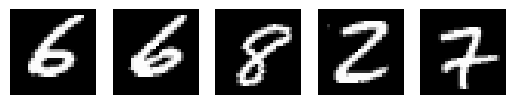

1/1 [==============================] - 0s 66ms/step


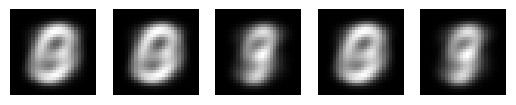

In [23]:
# Select a few images at random: look from n
n = np.random.randint(0, len(test_images)-5)

#  Plot a few images from n
f, ax = plt.subplots(1, 5)
for i, a in enumerate(range(n, n+5)):
    ax[i].imshow(test_images[a].reshape(img_rows, img_cols), cmap='gray')
    ax[i].axis('off')
plt.show()

# Get the prediction from the model
decoded_imgs = ae_model.predict(test_images[n:n+5])

# ... and plot them
f, ax = plt.subplots(1, 5)
for i, a in enumerate(range(n, n+5)):
    ax[i].imshow(decoded_imgs[i].reshape(img_rows, img_cols), cmap='gray')
    ax[i].axis('off')
plt.show()

<div class="alert alert-block alert-success">
  Our comment:
</div>

It seems that the bottleneck of the encoder is too small and we can't reconstruct the digits after encoding them. Thus, we lost too much information when encoding and we need to make the encoded layer larger and/or make the encoding more gradual by adding more layers.  Our previous analysis using PCA suggested this could happen, since it showed that two dimensions is far too little to represent all the variance of the dataset.

Do the same ( = build a new model) with a latent dimension that is largely higher than 2. Compare the visualizations and the images that are rebuilt. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [24]:
num_components = 196

# Input layer
input_layer = Input(shape=(img_rows*img_cols,), name='input')

# Encoding layer
latent_view = Dense(num_components, name='encoded')(input_layer)

# Decoding layer
output_layer = Dense(img_rows*img_cols, name='output')(latent_view)

ae_model_2 = Model(input_layer, output_layer, name='ae_model_2')

ae_model_2.summary()

Model: "ae_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoded (Dense)             (None, 196)               153860    
                                                                 
 output (Dense)              (None, 784)               154448    
                                                                 
Total params: 308308 (1.18 MB)
Trainable params: 308308 (1.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
loss = MeanSquaredError()
optimizer = SGD(learning_rate=1e-1) 

ae_model_2.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 50
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model_2.fit(train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images, test_images))

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 0.5889 - val_loss: 0.3751
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.3181 - val_loss: 0.2672
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2432 - val_loss: 0.2149
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2021 - val_loss: 0.1829
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1755 - val_loss: 0.1613
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1569 - val_loss: 0.1457
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1430 - val_loss: 0.1338
Epoch 8/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1321 - val_loss: 0.1243
Epoch 9/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1234 - val_loss: 0.1165
Epoch 10/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1160 - val_loss: 0.1100

469/469 [==============================] - 1s 3ms/step - loss: 0.1045 - val_loss: 0.0995
Epoch 13/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0998 - val_loss: 0.0953
Epoch 14/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0957 - val_loss: 0.0915
Epoch 15/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0920 - val_loss: 0.0881
Epoch 16/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0888 - val_loss: 0.0851
Epoch 17/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0858 - val_loss: 0.0824
Epoch 18/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0831 - val_loss: 0.0799
Epoch 19/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0807 - val_loss: 0.0776
Epoch 20/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0784 - val_loss: 0.0755
Epoch 21/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0763 - val_loss: 0.0736
Ep

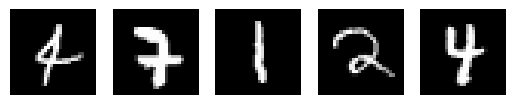

1/1 [==============================] - 0s 45ms/step


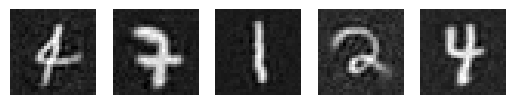

In [26]:
# Select a few images at random: look from n
n = np.random.randint(0, len(test_images)-5)

#  Plot a few images from n
f, ax = plt.subplots(1, 5)
for i, a in enumerate(range(n, n+5)):
    ax[i].imshow(test_images[a].reshape(img_rows, img_cols), cmap='gray')
    ax[i].axis('off')
plt.show()

# Get the prediction from the model
decoded_imgs = ae_model_2.predict(test_images[n:n+5])

# ... and plot them
f, ax = plt.subplots(1, 5)
for i, a in enumerate(range(n, n+5)):
    ax[i].imshow(decoded_imgs[i].reshape(img_rows, img_cols), cmap='gray')
    ax[i].axis('off')
plt.show()

<div class="alert alert-block alert-success">
  Our comment:
</div>

We observe that by making the encoded layer larger, we manage to not loose so much information in the encoding as before. 

### Bonus: De-noising Autoencoder

Now, we can implement a **de-noising autoencoder**. The following function will transform an array of images by adding it random noise. Create a new autoencoder model, this time with **more layers** and **non-linear activations** (like the ReLU) and train it to rebuild the de-noised images. Display some testing images, with noise, and re-built.

In [27]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape)
    return noisy_array

In [28]:
# Create a copy of the data with added noise
noisy_train_images = noise(train_images)
noisy_test_images = noise(test_images)

<div class='alert alert-block alert-info'>
            Code:</div>

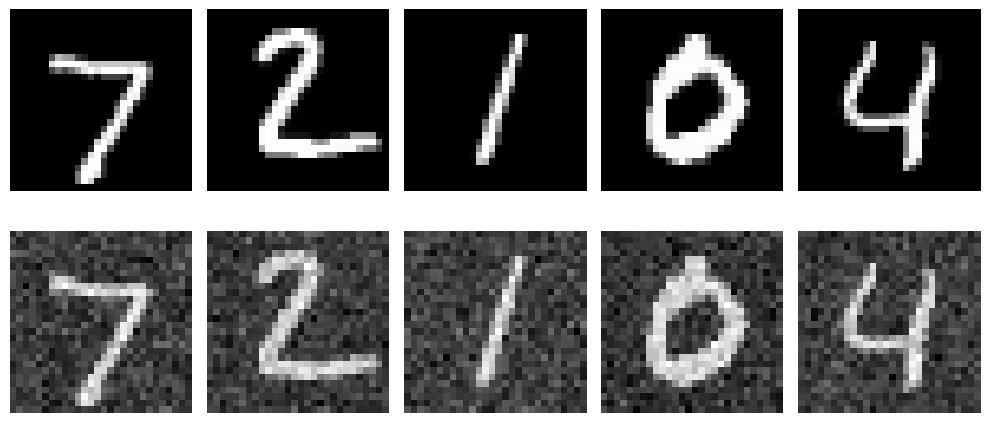

In [29]:
# Visualize some of the images with noise against the originals
f, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
    ax[1, i].imshow(noisy_test_images[i].reshape(img_rows, img_cols), cmap='gray')
    ax[1, i].axis('off')
    ax[0, i].imshow(test_images[i].reshape(img_rows, img_cols), cmap='gray')
    ax[0, i].axis('off')
f.tight_layout()
plt.show()

In [30]:
# Build a new model with more layers and Relu activations

# Input layer
input_layer = Input(shape=(img_rows*img_cols,), name='input')

# Encoding layer
encoded = Dense(576, activation='relu', name='encoded')(input_layer)
encoded = Dense(400, activation='relu')(encoded)
encoded = Dense(256, activation='relu')(encoded)

# Decoding layer
decoded = Dense(400, activation='relu')(encoded)
decoded = Dense(576, activation='relu')(encoded)
output_layer = Dense(img_rows*img_cols, activation='sigmoid', name='output')(decoded)

ae_model_3 = Model(input_layer, output_layer, name='ae_model_3')

ae_model_3.summary()

Model: "ae_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoded (Dense)             (None, 576)               452160    
                                                                 
 dense (Dense)               (None, 400)               230800    
                                                                 
 dense_1 (Dense)             (None, 256)               102656    
                                                                 
 dense_3 (Dense)             (None, 576)               148032    
                                                                 
 output (Dense)              (None, 784)               452368    
                                                                 
Total params: 1386016 (5.29 MB)
Trainable params: 138601

In [31]:
# Compile it but here, use noised data as inputs !

loss = MeanSquaredError()
optimizer = SGD(learning_rate=0.3)

ae_model_3.compile(optimizer=optimizer, loss=loss)

batch_size = 128
epochs = 10
history = ae_model_3.fit(noisy_train_images,
                         train_images,
                         epochs=epochs,
                         batch_size=batch_size,
                         verbose=1,
                         shuffle=True,
                         validation_data=(noisy_test_images, test_images))

Epoch 1/10
469/469 [==============================] - 4s 8ms/step - loss: 0.7722 - val_loss: 0.6841
Epoch 2/10
381/469 [=======================>......] - ETA: 0s - loss: 0.6552

469/469 [==============================] - 4s 8ms/step - loss: 0.6509 - val_loss: 0.6306
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.6149 - val_loss: 0.6063
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 0.5941 - val_loss: 0.5887
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 0.5797 - val_loss: 0.5767
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 0.5690 - val_loss: 0.5671
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 0.5602 - val_loss: 0.5587
Epoch 8/10
469/469 [==============================] - 3s 7ms/step - loss: 0.5518 - val_loss: 0.5532
Epoch 9/10
469/469 [==============================] - 3s 7ms/step - loss: 0.5461 - val_loss: 0.5467
Epoch 10/10
469/469 [==============================] - 3s 7ms/step - loss: 0.5408 - val_loss: 0.5426


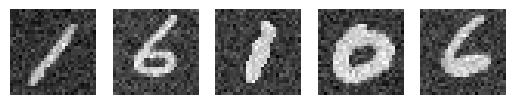

1/1 [==============================] - 0s 23ms/step


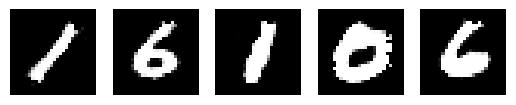

In [33]:
# Visualize the images rebuilt by the model !

# Select a few images at random: look from n
n = np.random.randint(0, len(test_images)-5)

#  Plot a few images from n
f, ax = plt.subplots(1, 5)
for i, a in enumerate(range(n, n+5)):
    ax[i].imshow(noisy_test_images[a].reshape(img_rows, img_cols), cmap='gray')
    ax[i].axis('off')
plt.show()

# Get the prediction from the model
decoded_imgs = ae_model_3.predict(noisy_test_images[n:n+5])

# ... and plot them
f, ax = plt.subplots(1, 5)
for i, a in enumerate(range(n, n+5)):
    ax[i].imshow(decoded_imgs[i].reshape(img_rows, img_cols), cmap='gray')
    ax[i].axis('off')
plt.show()

<div class="alert alert-block alert-success">
  Our comment:
</div>

We obtain a reasonably well denoised output.

Assuming that we normalize the images to be in the 0-1 range, what other loss function could we use ?
<div class='alert alert-block alert-warning'>
            Answer:</div>

We could use the Binary Cross-Entropy (BCE) loss function. BCE is particularly suitable for models that output probabilities, which aligns well with the nature of normalized image pixels falling between 0 and 1. BCE measures the distance between the probability distributions of the predicted and actual values, making it a good fit for tasks where the model outputs can be interpreted as probabilities, such as in image reconstruction tasks where the goal is to predict the probability of each pixel being activated.
